# Creating Regression Models to Predict Closing Price of NVDA
## Introduction to Machine Learning, Project 1
### Spencer Hirsch

## Problem Description

For Project 1 my goal is to accurately predict the stock price of Nvidia (NVDA). When I started working with machine learning last year, a project like this is something that I have been wanting to do and I thought this would be the perfect oppurtunity for me to work on it. 

Rather than just using the historical data for NVDA I will be using a variety of data that can influence the price. I collected data from the Down Jones Industrial Average (^DJI) and I manually calculated the Simple Moving Average of NVDA over a 5 day period as well as the Exponential Moving Average.

All of this data collection and processing resulted in a pandas dataframe that contained the following values: Date, NVDA_Open, NVDA_High, NVDA_Low, NVDA_Close, NVDA_Adj_Close, NVDA_Volume, NVDA_EMA_Daily_Avg, NVDA_SMA_Daily_Avg, DJIA_Open, DJIA_High, DJIA_Low, DJIA_Close, DJIA_Adj_Close, DJIA_Volume. 

Predicting stock price is a very difficult task to do, however, I had hopes that through the use of a variety of regression models I would be able to acheive results that would allow for the use of these models in real world applications. I have come to learn that the challenge was far more involved and difficult to acheive than I had originall thought. Thus, I used this project as more of an experiment to see what I would be able to acheive in accurate model performance.

#### Import Libraries used throughout project.

In [2]:
import sys
import warnings

import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from arch import arch_model


## Data Preparation

I collected data from Yahoo finance for this project, I originally was attempting to manually download the csv files for the data but I had run into some issues with collecting ^DJI data. I eventually found that there is a python library that allows you to load in data from yahoo finance into a csv.

Once this data was collected it was necessary for my to clean the data. Due to duplicate column names, such as 'Open', 'Close', etc. I made them more unique to avoid confusion. I also elimated duplicate columns such as 'Date' because both NVDA and ^DJI are read in from the same range.

In [256]:
'''
    For the end date you must chose n+1 because it will only include data
    up until this date.
'''

dji_data = yf.download('^DJI', start='1999-01-22', end='2024-03-21')
dji_data.to_csv("djia.csv")
print('DJIA data outputted to csv.')
dji_data = yf.download('NVDA', start='1999-01-22', end='2024-03-21')
dji_data.to_csv("nvda.csv")
print('NVDA data outputted to csv.')


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed

DJIA data outputted to csv.
NVDA data outputted to csv.


In [490]:
nvda_file = 'nvda.csv'
dji_file = 'dji.csv'

nvda_df = pd.read_csv(nvda_file)
dji_df = pd.read_csv(dji_file)

dji_df = dji_df.drop(columns = ['Date']) # Drop duplicate column
# nvda_df = nvda_df.drop(columns = ['Adj Close']) # Drop duplicate csolumn

# Clean up column names to make it more descriptive.
nvda_df.rename(columns={'Open': 'NVDA_Open', 'High': 'NVDA_High', 'Low': 'NVDA_Low', 
                        'Close': 'NVDA_Close', 'Adj Close': 'NVDA_Adj_Close', 
                        'Volume': 'NVDA_Volume'}, inplace=True) 

dji_df.rename(columns={'Open': 'DJIA_Open', 'High': 'DJIA_High', 'Low': 'DJIA_Low', 
                       'Close': 'DJIA_Close', 'Adj Close': 'DJIA_Adj_Close', 
                       'Volume': 'DJIA_Volume'}, inplace=True) 

## Manually calulate metrics to include in data.

To add more features to the data I decided to add the Simple Moving Average and the Exponential Moving Average to reflect the movement in the price over a 5 day period. I chose this 5 day period as the market is open Monday through Friday with the exception of bank holidays. Calculating these metrics I believe should allow for short term trends to be more prevalent in the training data.

In [491]:
'''
    Calculate the Simple Moving Average (SMA) and the Exponential Moving Average (EMA)
    over a 5 day period in the data to indentify any short term trends.
'''

nvda_df['NVDA_SMA_Daily_Avg'] = nvda_df['NVDA_Close'].rolling(window=5).mean()
nvda_df['NVDA_EMA_Daily_Avg'] = nvda_df['NVDA_Close'].ewm(span=5, adjust=False).mean()

### NVDA Dataframe

In [492]:
nvda_df

,Date,NVDA_Open,NVDA_High,NVDA_Low,NVDA_Close,NVDA_Adj_Close,NVDA_Volume,NVDA_SMA_Daily_Avg,NVDA_EMA_Daily_Avg
0,1999-01-22,0.437500,0.488281,0.388021,0.410156,0.376237,271468800,NaN,0.410156
1,1999-01-25,0.442708,0.458333,0.410156,0.453125,0.415653,51048000,NaN,0.424479
2,1999-01-26,0.458333,0.467448,0.411458,0.417969,0.383404,34320000,NaN,0.422309
3,1999-01-27,0.419271,0.429688,0.395833,0.416667,0.382210,24436800,NaN,0.420428
4,1999-01-28,0.416667,0.419271,0.412760,0.415365,0.381015,22752000,0.422656,0.418741
...,...,...,...,...,...,...,...,...,...
6326,2024-03-14,895.770020,906.460022,866.000000,879.440002,879.440002,60231800,888.094006,888.767201
6327,2024-03-15,869.299988,895.460022,862.570007,878.369995,878.369995,64019300,888.712000,885.301466
6328,2024-03-18,903.880005,924.049988,870.849976,884.549988,884.549988,66897600,894.073999,885.050973
6329,2024-03-19,867.000000,905.440002,850.099976,893.979980,893.979980,67217100,889.043994,888.027309


### ^DJI Dataframe

In [263]:
dji_df

,DJIA_Open,DJIA_High,DJIA_Low,DJIA_Close,DJIA_Adj_Close,DJIA_Volume
0,9264.080078,9264.589844,9088.490234,9120.669922,9120.669922,93640000
1,9120.669922,9203.830078,9063.259766,9203.320312,9203.320312,89250000
2,9203.320312,9329.990234,9188.379883,9324.580078,9324.580078,90780000
3,9325.360352,9385.860352,9195.339844,9200.230469,9200.230469,88800000
4,9203.570312,9301.150391,9203.570312,9281.330078,9281.330078,80490000
...,...,...,...,...,...,...
6326,39122.390625,39160.250000,38704.359375,38905.660156,38905.660156,375810000
6327,38809.648438,38928.128906,38618.199219,38714.769531,38714.769531,774360000
6328,38826.929688,38898.410156,38760.789062,38790.429688,38790.429688,327950000
6329,38819.609375,39122.710938,38761.281250,39110.761719,39110.761719,310610000


### Combine dataframes

After constructing the two individual dataframes, I combined them into one single dataframe for the models to eventually use. I then export this to a csv for the models to pull the data and process them individually if necessary.

In [264]:
combined_df = pd.concat([nvda_df, dji_df], axis=1)
combined_df.to_csv('combined.csv', index=False)  
combined_df

,Date,NVDA_Open,NVDA_High,NVDA_Low,NVDA_Close,NVDA_Volume,NVDA_SMA_Daily_Avg,NVDA_EMA_Daily_Avg,DJIA_Open,DJIA_High,DJIA_Low,DJIA_Close,DJIA_Adj_Close,DJIA_Volume
0,1999-01-22,0.437500,0.488281,0.388021,0.410156,271468800,NaN,0.410156,9264.080078,9264.589844,9088.490234,9120.669922,9120.669922,93640000
1,1999-01-25,0.442708,0.458333,0.410156,0.453125,51048000,NaN,0.424479,9120.669922,9203.830078,9063.259766,9203.320312,9203.320312,89250000
2,1999-01-26,0.458333,0.467448,0.411458,0.417969,34320000,NaN,0.422309,9203.320312,9329.990234,9188.379883,9324.580078,9324.580078,90780000
3,1999-01-27,0.419271,0.429688,0.395833,0.416667,24436800,NaN,0.420428,9325.360352,9385.860352,9195.339844,9200.230469,9200.230469,88800000
4,1999-01-28,0.416667,0.419271,0.412760,0.415365,22752000,0.422656,0.418741,9203.570312,9301.150391,9203.570312,9281.330078,9281.330078,80490000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6326,2024-03-14,895.770020,906.460022,866.000000,879.440002,60231800,888.094006,888.767201,39122.390625,39160.250000,38704.359375,38905.660156,38905.660156,375810000
6327,2024-03-15,869.299988,895.460022,862.570007,878.369995,64019300,888.712000,885.301466,38809.648438,38928.128906,38618.199219,38714.769531,38714.769531,774360000
6328,2024-03-18,903.880005,924.049988,870.849976,884.549988,66897600,894.073999,885.050973,38826.929688,38898.410156,38760.789062,38790.429688,38790.429688,327950000
6329,2024-03-19,867.000000,905.440002,850.099976,893.979980,67217100,889.043994,888.027309,38819.609375,39122.710938,38761.281250,39110.761719,39110.761719,310610000


## Initial Data Visualization

### Show stock price of NVDA over time

Text(0, 0.5, 'Price ($)')

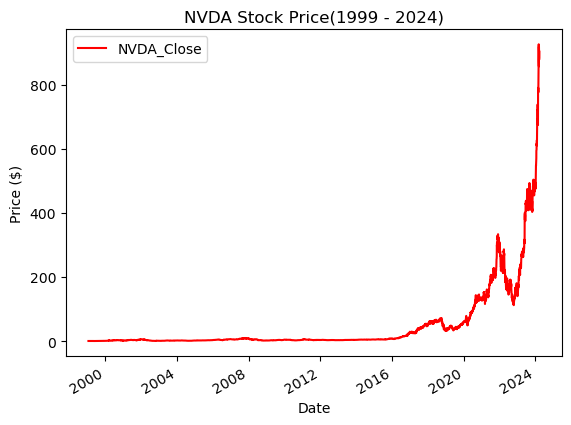

In [503]:
data = pd.read_csv('combined.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.plot(x='Date', y='NVDA_Open', kind='line', color='red')
plt.title('NVDA Stock Price(1999 - 2024)')
plt.ylabel('Price ($)')

### Show ^DJI Over same time period as NVDA

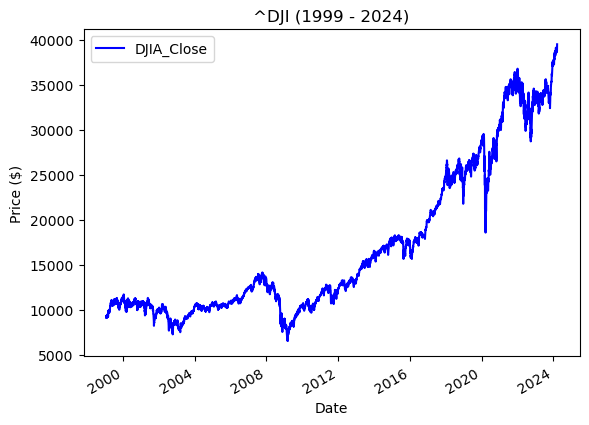

In [505]:
data = pd.read_csv('combined.csv')
data['Date'] = pd.to_datetime(data['Date'])

data.plot(x='Date', y='DJIA_Close', kind='line', color='blue')
plt.title('^DJI (1999 - 2024)')
plt.ylabel('Price ($)')
plt.show()

## Training and Tuning Models

### Linear Regression Model

Creating a Linear Regression model as a baseline to predict stock price.

In [22]:
data = pd.read_csv('combined.csv')
data['Date'] = data['Date'].str.replace('-', '')
data_y = data['NVDA_Close'].to_numpy()[4::]
data_x = data.drop(columns=['NVDA_Close'])
data_x['Date'] = data_x['Date'].str.replace('-', '')
data_x = data_x.to_numpy()[4::]

lr_model = LinearRegression()
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.3, random_state=42)
lr_model.fit(train_x, train_y)

predictions = lr_model.predict(test_x)

print('We can see some clear overfitting with the following results:\n')
print('The r^2 score is', r2_score(test_y, predictions))
print('The mean squared error is', mean_squared_error(test_y, predictions))
print('The mean absolute error is', mean_absolute_error(test_y, predictions))

We can see some clear overfitting with the following results:

The r^2 score is 0.9998705304728243
The mean squared error is 1.3497416140509602
The mean absolute error is 0.4454123546255314


### Compare the predicted results to the true results.

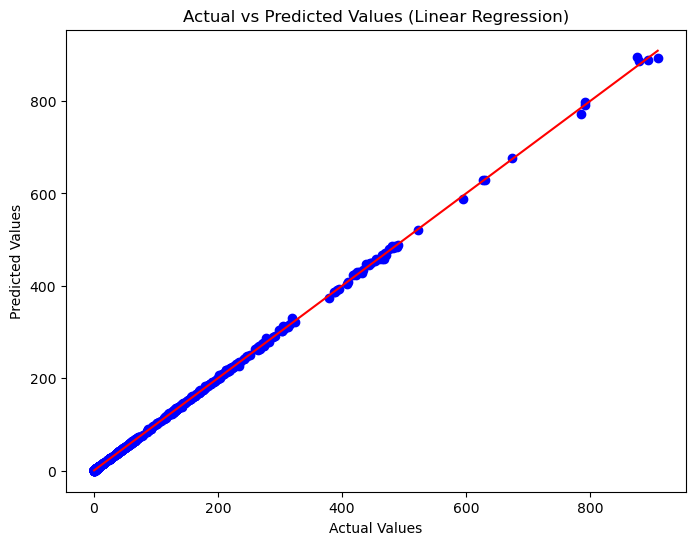

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(test_y, predictions, color='blue')
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Linear Regression)')
plt.show()

### Plot the predicted results in compairson to the true results over all stock data.

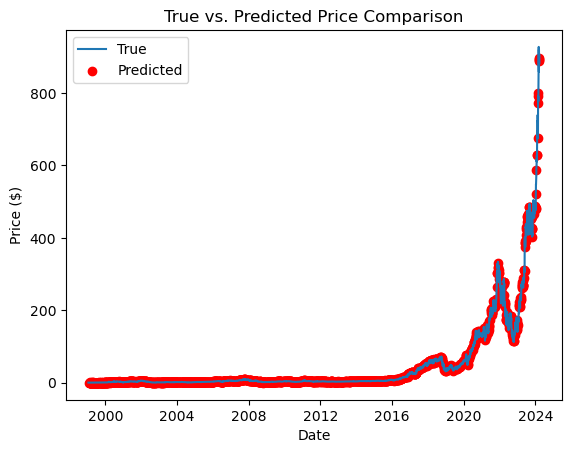

In [25]:
data['Date'] = pd.to_datetime(data['Date'])
plt.plot(data['Date'], data['NVDA_Close'], label='True')
df = pd.DataFrame(test_x)
df[0] = pd.to_datetime(df[0], format='%Y%m%d')
plt.scatter(df[0], predictions, color='red', label='Predicted')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.title('True vs. Predicted Price Comparison')
plt.legend()
plt.show()

### Hyperparameter tuning Linear Regression Model

In [64]:
data = pd.read_csv('combined.csv')
data['Date'] = data['Date'].str.replace('-', '')
data_y = data['NVDA_Close'].to_numpy()[4::]
data_x = data.drop(columns=['NVDA_Close'])
data_x['Date'] = data_x['Date'].str.replace('-', '')
data_x = data_x.to_numpy()[4::]

lr_model = LinearRegression()
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.3, random_state=42)

param_grid = {
    'fit_intercept': [True, False],
}

grid_search = GridSearchCV(lr_model, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(train_x, train_y)

print('Best hyperparameters: ', grid_search.best_params_)
print('Best MSE: ', -grid_search.best_score_)

Best hyperparameters:  {'fit_intercept': False}
Best MSE:  1.3709790371260149


### Training ARIMA Model

Autoregressive Integrate Moving Average (ARIMA) models are used for time series forecasting. I chose this model because I assumed it would be a good choice for finance predictions. These models can be used to predict a time series for future prices based on the historical data.

They consist of 3 primary parameters, p, q, and d.

P is the order of the autoregressive component.
    Relationship between observations and number of lagged events.

Q order of the moving average.
    This better helps the model understand the patterns in the data.

D degree of differencing required to make the model stationary.
    Stationary means there is not much movement in the mean, variance, and covariance over time.




Mean Squared Error (MSE): 54022.52714574289


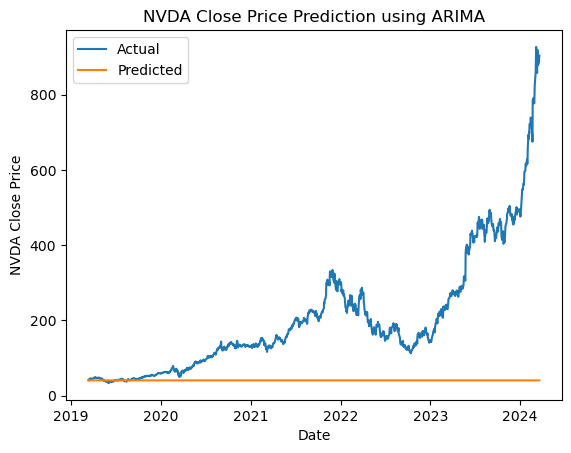

In [29]:
'''
    Baseline ARIMA model, used to measure growth in performance after hyper-parameter tuning takes place.
'''

warnings.filterwarnings("ignore")
data = pd.read_csv('combined.csv')[4::]     # Read data.

data['Date'] = pd.to_datetime(data['Date'])     # Convert column to datetime format.
data.set_index(pd.DatetimeIndex(data['Date']).to_period('D'), inplace=True)

# Split data into train and test data.

train = data.iloc[:int(len(data) * 0.8)]
test = data.iloc[int(len(data) * 0.8):]

model = ARIMA(train['NVDA_Close'], order=(1, 1, 1)) 
fitted = model.fit()    # Train model.

predictions = fitted.forecast(steps=len(test))  # Make predictions

mse = mean_squared_error(test['NVDA_Close'], predictions)
print(f'Mean Squared Error (MSE): {mse}')

test.index = pd.to_datetime(test.index.astype(str))

plt.plot(test.index, test['NVDA_Close'], label='Actual')
plt.plot(test.index, predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('NVDA Close Price')
plt.title('NVDA Close Price Prediction using ARIMA')
plt.legend()
plt.show()


As we can see with the above graph that there is not much benefit to using the ARIMA model as it poorly predicts the true price of the stock.

### Tuning ARIMA Model

Next we will perform a grid search on the ARIMA model to find the best values for p, d, and q that returns the smalles MSE value.

Due to computation constraints I will be limiting the search to 0 - 3 for all values.

Best Mean Squared Error (MSE): 45633.320650188885
Best P: 1, Best D: 3, Best Q: 3


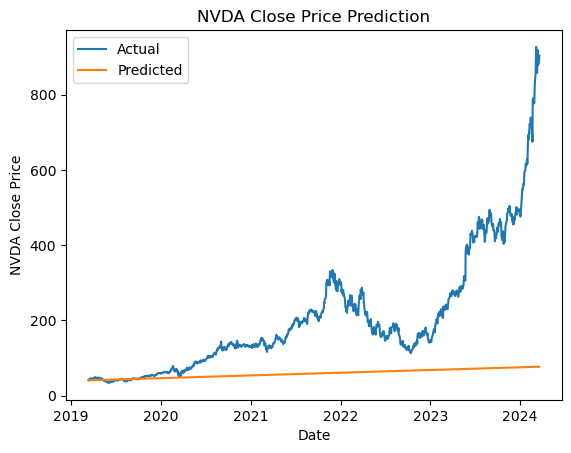

In [30]:
data = pd.read_csv('combined.csv')[4::] # Read data.

data['Date'] = pd.to_datetime(data['Date'])
data.set_index(pd.DatetimeIndex(data['Date']).to_period('D'), inplace=True)

# Split data into train and test.
train = data.iloc[:int(len(data) * 0.8)]
test = data.iloc[int(len(data) * 0.8):]

# Initialize lists with values to test.
p_vals = range(0, 4)
d_vals = range(0, 4)
q_vals = range(0, 4)

# Used to store best performing model information.
best_params = None
best_preds = None
best_mse = sys.maxsize

'''
    Iterate through all values in the lists and save the best model by comparing the MSE to the
    current smallest value.
'''
for p in p_vals:
    for d in d_vals:
        for q in q_vals:
            model = ARIMA(train['NVDA_Close'], order=(p, d, q))
            arima_model = model.fit()

            predictions = arima_model.forecast(steps=len(test))

            mse = mean_squared_error(test['NVDA_Close'], predictions)
            if mse < best_mse:
                best_mse = mse
                best_params = [p, d, q]
                best_preds = predictions

# Once model is found output the results.
print(f'Best Mean Squared Error (MSE): {best_mse}')
print(f'Best P: {best_params[0]}, Best D: {best_params[1]}, Best Q: {best_params[2]}')


test.index = pd.to_datetime(test.index.astype(str))
'''
    Compare results from the best ARIMA model to the true values of the stock price.
'''
plt.plot(test.index, test['NVDA_Close'], label='Actual')
plt.plot(test.index, best_preds, label='Predicted')
plt.xlabel('Date')
plt.ylabel('NVDA Close Price')
plt.title('NVDA Close Price Prediction')
plt.legend()
plt.show()


We can see in the above graph there is a slight improvement in the model with the hyper-parameter tuning but it is still performing poorly.

### Additional Tuning with New Knowledge

While preparing to train the GARCH model, I learned of some function that allow you to see the percent change in the data at certain times. With this data I can see the number of days where there is the greatest percent change allowing me to manually adjust the parameters to see if I can find a better performing model.

Mean Squared Error (RMSE): 34813.61209176357


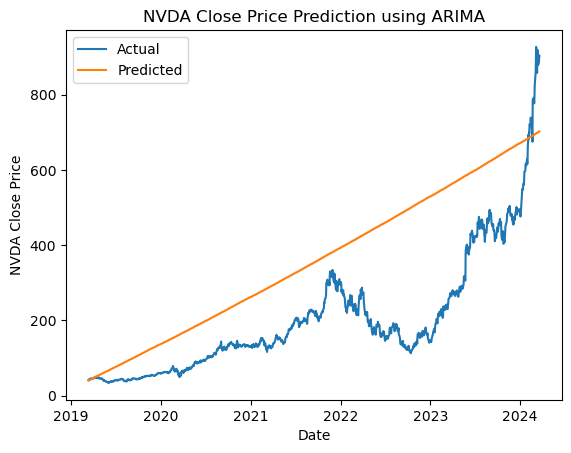

In [460]:
from statsmodels.tsa.arima.model import ARIMA

data = pd.read_csv('combined.csv')[4::]

data['Date'] = pd.to_datetime(data['Date'])
data.set_index(pd.DatetimeIndex(data['Date']).to_period('D'), inplace=True)

train = data.iloc[:int(len(data) * 0.8)]
test = data.iloc[int(len(data) * 0.8):]

model = ARIMA(train['NVDA_Close'], order=(7, 3, 2))
fitted = model.fit()

predictions = fitted.forecast(steps=len(test))

mse = mean_squared_error(test['NVDA_Close'], predictions)
print(f'Mean Squared Error (RMSE): {mse}')

test.index = pd.to_datetime(test.index.astype(str))
# Plot actual vs predicted
plt.plot(test.index, test['NVDA_Close'], label='Actual')
plt.plot(test.index, predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('NVDA Close Price')
plt.title('NVDA Close Price Prediction using ARIMA')
plt.legend()
plt.show()


We can see that with the new manually selected parameters for training the ARIMA model there was even more improvement compared to the grid search performed earlier. We now have our smallest MSE for ARIMA being 34,813. This was unforntuately the best performing model that I was able to train using the ARIMA method.

## Training GARCH Model

The Generalized Autoregressive Conditional Heteroskedasticity (GARCH) is another time series forecasting model that allows for future predictions based on previous data. I chose this one as I believed that it would be beneficial when looking at stock prices. However, I learned that it is better to be used for predicting the volatility of a stock. So for this last portion, rather than predicting stock price I will be using the model to predict volatility in the stock price.

Before training the model I analyzed the percent change in the stock price to model the volatility of the price of the stock over the course of its existence.

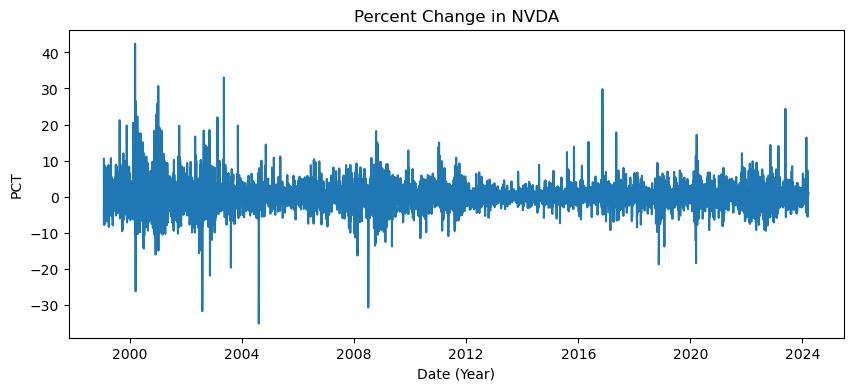

In [3]:
data = pd.read_csv('combined.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
returns = 100 * data['NVDA_Close'].pct_change().dropna()
plt.figure(figsize=(10, 4))
plt.plot(returns)
plt.title('Percent Change in NVDA')
plt.xlabel('Date (Year)')
plt.ylabel('PCT')
plt.show()

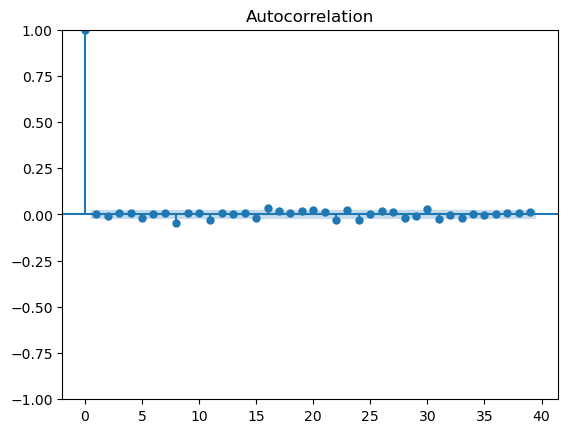

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(returns)
plt.show()

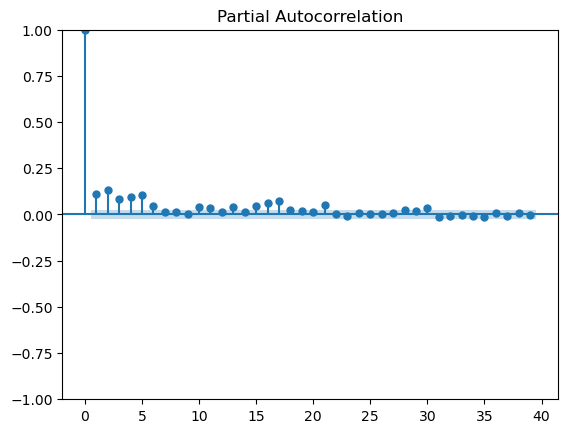

In [5]:
plot_pacf(returns**2)
plt.show()

Now I will train a benchmark model with basic p and q values to evaluate its performance.

In [48]:
from arch import arch_model

garch_model = arch_model(returns, vol='GARCH', p=1, q=1, rescale=True)
garch_trained = garch_model.fit()


Iteration:      1,   Func. Count:      6,   Neg. LLF: 46119.37536677425
Iteration:      2,   Func. Count:     16,   Neg. LLF: 127575171845.09656
Iteration:      3,   Func. Count:     24,   Neg. LLF: 65096917.965894155
Iteration:      4,   Func. Count:     30,   Neg. LLF: 16671.411226921304
Iteration:      5,   Func. Count:     36,   Neg. LLF: 16541.775780187207
Iteration:      6,   Func. Count:     41,   Neg. LLF: 1723072282.8730626
Iteration:      7,   Func. Count:     47,   Neg. LLF: 17758.59668177527
Iteration:      8,   Func. Count:     55,   Neg. LLF: 25772.627768698534
Iteration:      9,   Func. Count:     61,   Neg. LLF: 16536.851963871188
Iteration:     10,   Func. Count:     66,   Neg. LLF: 16536.834074739803
Iteration:     11,   Func. Count:     71,   Neg. LLF: 16536.833747074765
Iteration:     12,   Func. Count:     76,   Neg. LLF: 16536.833704338635
Iteration:     13,   Func. Count:     81,   Neg. LLF: 16536.833700505438
Iteration:     14,   Func. Count:     85,   Neg. LLF:

In [49]:
garch_trained.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             NVDA_Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -16536.8
Distribution:                  Normal   AIC:                           33081.7
Method:            Maximum Likelihood   BIC:                           33108.7
                                        No. Observations:                 6330
Date:                Sat, Mar 30 2024   Df Residuals:                     6329
Time:                        23:23:39   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2318  5.400e-02      4.293  1.765e-05 [  0.126,  0.338]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1002      0.212      0.472      0.637    [ -0.316,  0.516]
alpha[1]       0.0479  6.720e-02      0.713      0.476 [-8.383e-02,  0.180]
beta[1]        0.9472  7.627e-02     12.419  2.073e-35    [  0.798,  1.097]
===========================================================================

Covariance estimator: robust
"""

In [50]:
garch_model = arch_model(returns, vol='GARCH', p=1, q=2, rescale=True)
garch_trained = garch_model.fit()
garch_trained.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 42404.018112736616
Iteration:      2,   Func. Count:     17,   Neg. LLF: 32825.42181475968
Iteration:      3,   Func. Count:     26,   Neg. LLF: 16656.294285367447
Iteration:      4,   Func. Count:     33,   Neg. LLF: 16590.92540881372
Iteration:      5,   Func. Count:     40,   Neg. LLF: 16718.349048632313
Iteration:      6,   Func. Count:     47,   Neg. LLF: 16539.06604375871
Iteration:      7,   Func. Count:     54,   Neg. LLF: 16606.08370955417
Iteration:      8,   Func. Count:     61,   Neg. LLF: 16568.358291124252
Iteration:      9,   Func. Count:     68,   Neg. LLF: 21827.65855251611
Iteration:     10,   Func. Count:     76,   Neg. LLF: 16534.493766347332
Iteration:     11,   Func. Count:     82,   Neg. LLF: 16534.380463180823
Iteration:     12,   Func. Count:     88,   Neg. LLF: 16534.370671900822
Iteration:     13,   Func. Count:     94,   Neg. LLF: 16534.370139118244
Iteration:     14,   Func. Count:    100,   Neg. LLF: 16

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             NVDA_Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -16534.4
Distribution:                  Normal   AIC:                           33078.7
Method:            Maximum Likelihood   BIC:                           33112.5
                                        No. Observations:                 6330
Date:                Sat, Mar 30 2024   Df Residuals:                     6329
Time:                        23:23:51   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2340  5.121e-02      4.569  4.900e-06 [  0.134,  0.334]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1288      0.211      0.610      0.542    [ -0.285,  0.543]
alpha[1]       0.0655  6.864e-02      0.955      0.340 [-6.899e-02,  0.200]
beta[1]        0.4533      0.233      1.947  5.149e-02 [-2.923e-03,  0.909]
beta[2]        0.4750      0.223      2.134  3.285e-02  [3.871e-02,  0.911]
===========================================================================

Covariance estimator: robust
"""

In [55]:
forecasts = garch_trained.forecast()
forecasted_volatility = forecasts.variance['h.1'].values

actual_volatility = returns ** 2

mse = mean_squared_error(actual_volatility[-len(forecasted_volatility):], forecasted_volatility)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 136.54730078791698


In [6]:
import numpy as np

rolling_predictions = []
test_size = 365

for i in range(test_size):
    train = returns[:-(test_size-i)]
    # garch_model = arch_model(returns, vol='GARCH', p=1, q=2, rescale=True)
    garch_model = arch_model(returns, vol='GARCH', p=1, q=2)
    garch_trained = garch_model.fit()
    pred = garch_trained.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))


Iteration:      1,   Func. Count:      7,   Neg. LLF: 42404.018112736616
Iteration:      2,   Func. Count:     17,   Neg. LLF: 32825.42181475968
Iteration:      3,   Func. Count:     26,   Neg. LLF: 16656.294285367447
Iteration:      4,   Func. Count:     33,   Neg. LLF: 16590.92540881372
Iteration:      5,   Func. Count:     40,   Neg. LLF: 16718.349048632313
Iteration:      6,   Func. Count:     47,   Neg. LLF: 16539.06604375871
Iteration:      7,   Func. Count:     54,   Neg. LLF: 16606.08370955417
Iteration:      8,   Func. Count:     61,   Neg. LLF: 16568.358291124252
Iteration:      9,   Func. Count:     68,   Neg. LLF: 21827.65855251611
Iteration:     10,   Func. Count:     76,   Neg. LLF: 16534.493766347332
Iteration:     11,   Func. Count:     82,   Neg. LLF: 16534.380463180823
Iteration:     12,   Func. Count:     88,   Neg. LLF: 16534.370671900822
Iteration:     13,   Func. Count:     94,   Neg. LLF: 16534.370139118244
Iteration:     14,   Func. Count:    100,   Neg. LLF: 16

In [7]:
rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-365:])

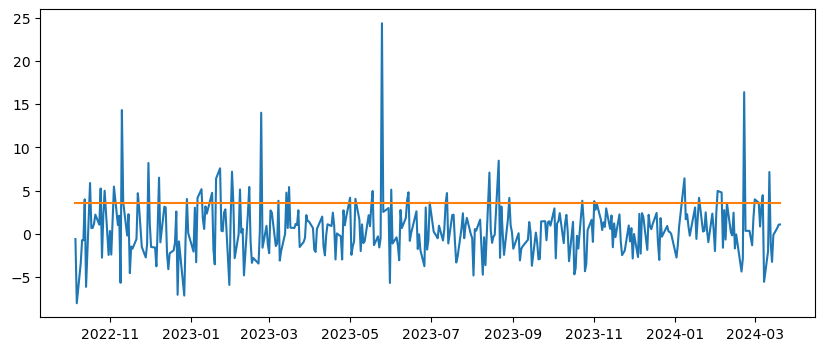

In [11]:
plt.figure(figsize=(10, 4))
true, = plt.plot(returns[-365:])
preds, = plt.plot(rolling_predictions)

### Tuning GARCH Model



In [6]:
p_vals= range(1, 5)
q_vals = range(1, 5)

best_garch_trained = None
best_mse = sys.maxsize
best_vals = [0, 0]
for p_val in p_vals:
    for q_val in q_vals:
        garch_model = arch_model(returns, vol='GARCH', p=p_val, q=q_val, rescale=True)
        garch_trained = garch_model.fit()
        forecasts = garch_trained.forecast()
        forecasted_volatility = forecasts.variance['h.1'].values
        actual_volatility = returns ** 2
        mse = mean_squared_error(actual_volatility[-len(forecasted_volatility):], forecasted_volatility)
        if mse < best_mse:
            best_mse = mse
            best_garch_trained = garch_trained
            best_vals = [p_val, q_val]

print("Mean Squared Error (MSE):", best_mse)
print(f"Best P: {best_vals[0]}, Best Q: {best_vals[1]}")
best_garch_trained.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 46119.37536677425
Iteration:      2,   Func. Count:     16,   Neg. LLF: 127575171845.09656
Iteration:      3,   Func. Count:     24,   Neg. LLF: 65096917.965894155
Iteration:      4,   Func. Count:     30,   Neg. LLF: 16671.411226921304
Iteration:      5,   Func. Count:     36,   Neg. LLF: 16541.775780187207
Iteration:      6,   Func. Count:     41,   Neg. LLF: 1723072282.8730626
Iteration:      7,   Func. Count:     47,   Neg. LLF: 17758.59668177527
Iteration:      8,   Func. Count:     55,   Neg. LLF: 25772.627768698534
Iteration:      9,   Func. Count:     61,   Neg. LLF: 16536.851963871188
Iteration:     10,   Func. Count:     66,   Neg. LLF: 16536.834074739803
Iteration:     11,   Func. Count:     71,   Neg. LLF: 16536.833747074765
Iteration:     12,   Func. Count:     76,   Neg. LLF: 16536.833704338635
Iteration:     13,   Func. Count:     81,   Neg. LLF: 16536.833700505438
Iteration:     14,   Func. Count:     85,   Neg. LLF:

/Users/spencerhirsch/opt/anaconda3/envs/vehid/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/spencerhirsch/opt/anaconda3/envs/vehid/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/spencerhirsch/opt/anaconda3/envs/vehid/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/spencerhirsch/opt/anaconda3/envs/vehid/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be remo

Iteration:      1,   Func. Count:     10,   Neg. LLF: 38509.78369605713
Iteration:      2,   Func. Count:     22,   Neg. LLF: 3207347.835402704
Iteration:      3,   Func. Count:     33,   Neg. LLF: 18396.160304805773
Iteration:      4,   Func. Count:     44,   Neg. LLF: 16633.491277055055
Iteration:      5,   Func. Count:     54,   Neg. LLF: 16573.473723034094
Iteration:      6,   Func. Count:     64,   Neg. LLF: 16546.572880625088
Iteration:      7,   Func. Count:     74,   Neg. LLF: 17487.980954408908
Iteration:      8,   Func. Count:     84,   Neg. LLF: 16654.526934956113
Iteration:      9,   Func. Count:     94,   Neg. LLF: 16537.63602659059
Iteration:     10,   Func. Count:    104,   Neg. LLF: 16537.79201787719
Iteration:     11,   Func. Count:    114,   Neg. LLF: 16536.942391329045
Iteration:     12,   Func. Count:    124,   Neg. LLF: 16538.82219154042
Iteration:     13,   Func. Count:    134,   Neg. LLF: 16530.45813681237
Iteration:     14,   Func. Count:    143,   Neg. LLF: 165

/Users/spencerhirsch/opt/anaconda3/envs/vehid/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/spencerhirsch/opt/anaconda3/envs/vehid/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/spencerhirsch/opt/anaconda3/envs/vehid/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/spencerhirsch/opt/anaconda3/envs/vehid/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be remo

Iteration:     22,   Func. Count:    238,   Neg. LLF: 154158.1978231335
Optimization terminated successfully    (Exit mode 0)
            Current function value: 16529.039121812635
            Iterations: 23
            Function evaluations: 244
            Gradient evaluations: 22
Iteration:      1,   Func. Count:      9,   Neg. LLF: 46098.07639903645
Iteration:      2,   Func. Count:     22,   Neg. LLF: 28111.946707868206
Iteration:      3,   Func. Count:     33,   Neg. LLF: 20717.30224800281
Iteration:      4,   Func. Count:     43,   Neg. LLF: 16668.500763935786
Iteration:      5,   Func. Count:     52,   Neg. LLF: 16541.702789751944
Iteration:      6,   Func. Count:     61,   Neg. LLF: 16539.415905576625
Iteration:      7,   Func. Count:     70,   Neg. LLF: 16609.667388727496
Iteration:      8,   Func. Count:     80,   Neg. LLF: 16538.09198217627
Iteration:      9,   Func. Count:     89,   Neg. LLF: 16619.732714888876
Iteration:     10,   Func. Count:     99,   Neg. LLF: 16535.386

/Users/spencerhirsch/opt/anaconda3/envs/vehid/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/spencerhirsch/opt/anaconda3/envs/vehid/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/spencerhirsch/opt/anaconda3/envs/vehid/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/spencerhirsch/opt/anaconda3/envs/vehid/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be remo

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             NVDA_Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -16530.9
Distribution:                  Normal   AIC:                           33075.9
Method:            Maximum Likelihood   BIC:                           33123.2
                                        No. Observations:                 6330
Date:                Mon, Apr 01 2024   Df Residuals:                     6329
Time:                        13:35:09   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2310  4.611e-02      5.010  5.436e-07 [  0.141,  0.321]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1568      0.189      0.830      0.406    [ -0.213,  0.527]
alpha[1]       0.0933  6.969e-02      1.338      0.181 [-4.332e-02,  0.230]
beta[1]        0.2244      0.241      0.931      0.352    [ -0.248,  0.697]
beta[2]        0.1019      0.316      0.322      0.747    [ -0.517,  0.721]
beta[3]        0.3745      0.376      0.997      0.319    [ -0.362,  1.111]
beta[4]        0.1992      0.243      0.821      0.412    [ -0.277,  0.675]
===========================================================================

Covariance estimator: robust
"""

In [7]:
import numpy as np

rolling_predictions = []
test_size = 365

for i in range(test_size):
    train = returns[:-(test_size-i)]
    garch_model = arch_model(returns, vol='GARCH', p=1, q=4, rescale=True)
    garch_trained = garch_model.fit(disp='off')
    pred = garch_trained.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [8]:
rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-365:])

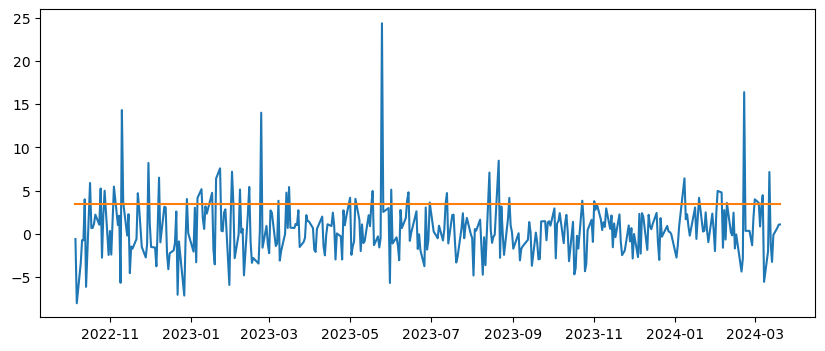

In [9]:
plt.figure(figsize=(10, 4))
true, = plt.plot(returns[-365:])
preds, = plt.plot(rolling_predictions)

We can see that even after tuning the model is still not good at predicting volatility in the stock price.

## Conclusions

Overall, I did acheive what I set out to do for the most part. I ran in to quite a few issues throughout this project including data collection. Once I got the data there were a few things that I had to do to it to get it properly prepared to be used with the different models. The linear regression model, I felt went the smoothest. I do have concerns however, with the results that I am getting from that model and worry that it may be overfit. The ARIMA model was interesting to work with and I had a variety of issues with it. Once I got the model working I was receiving very poor results and even after tuning the results are not great. Finally, the GARCH model was my most difficult model to work with. I set out in hopes of using the GARCH model to predict the stock price, however, I learned that GARCH is not intended to be used this way. I shifted my focus on this model in attempt to predict the volatility in the sock price instead, however those results still  did not come out as anticipated.

This project made me realize that in machine learning the results that we get are not always what we set out to do. This was very challenging for me because I wanted to create better models that would more accurately reflect the price of the stock. It was a great learning oppurtunity because it allowed me to get more experience in models that we had not covered in class. Throughout the notebook I record the conclusions of each model with a variety of charts comparing the results from each study to the true data.